# TD4: Résaux de neurones : modèles de taux de décharge

Dans ce TD, nous allons étudier la dynamique de réseaux de neurones où différentes *populations de neurones* sont représentés par leur taux de décharge moyen. Ces populations peuvent être couplées par des connexions synaptiques, ce qui rend la dynamique de ces modèles potentiellement très riche.

Par ailleurs, ces modèles sont aussi très étudiés comme une approximation de réseaux récurrents de neurones, où le couplage entre toutes les unités, avec certaines contraintes, peut produire n'importe quel dynamique souhaité suite à un apprentissage des poids des connexions.

Ici, nous allons d'abord étudier des réseaux à basse dimension, c'est-à-dire avec une ou deux populations de neurones, pour développer une compréhension des modèles à taux de décharge. Si le temps le permet, nous pourrons implémenter une version du "bump attractor model" que nous avons rapidement vu dans le cours.

## 1| Une seule population avec connexions récurrentes

Pour une seule population de neurones, la dynamique du taux de décharge $r(t)$ est donné par l'équation différentielle

$$\frac{dr}{dt} = \frac{\Phi(I_{ext}+wr(t)) - r(t)}{\tau},$$ 

où $\Phi(I)$ est la *fonction de transfert*, ou courbe $f-I$, qui donne le taux de décharge stationnaire du réseau pour un courant constant $I$. Dans le modèle, le courant synaptique que la population reçoit est donné par la somme d'une courant provénant d'autres régions du cervau ou d'autres populations de neurones, $I_{ext}$, et le courant synaptique lié aux connexions récurrentes, proportionnel au taux de décharge de la population même, $I_{rec}=w r(t)$, avec un poids de connexion effective $w$. Pour des neurones excitateurs, $w>0$, pour des neurones inhibiteurs, $w<0$. Enfin, $\tau$ est le temps caractéristique de la relaxation du taux de décharge vers la valeur stationnaire. 



### La fonction de transfert

On peut choisir différentes fonctions pour $\Phi(I)$, seulement il faut que la fonction soit toujours positive, $\Phi(I)\ge 0$, et monotone, $\Phi(I_1)\ge \Phi(I_2)$ si $I_1>I_2$.

Ici, on va utiliser une sigmoïde, 
$$\Phi(I) = r_{max} \frac{\tanh[\kappa(I-I_{half})] + 1}{2},$$
avec les paramètres suivants : $r_{max}$ - le taux de décharge maximale, $\kappa$ - la 'raideur' de la courbe $f-I$, et $I_{half}$ - le courant pour lequel le taux de décharge sera $r_{max}/2$.

Ce choix est assez "générique" dans le sens où la fonction ressemble à des courbes $f-I$ observées, tout en étant très aisément parametrisable, et implémenter numériquement. L'inverse et la dérivé sont également connues, ce qui s'averera utile pour des calculs. 

**Remarque :** Une fois implémenté, nous n'avons plus à nous soucier de la fonction de transfert dans nos simulations ou calculs, qu'elle soit compliquée ou non !


In [1]:
# import necessary modules for numerics and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Definition of the f-I curve 

# set standard parameters 
# --> these will be used as default parameters
# in the function definitions
rmax = 500.0     # (could be Hz)
Ihalf = 10.0   # (could be pA)
kappa = 0.2  # (1/unit of current)

# f-I curve
def fI(I):
    """fI(I, kwargs**) returns the population firing rate (in Hz) 
    for a given input current I (in mV)."""
    return rmax*0.5*(1.0+np.tanh((I-Ihalf)*kappa))

# we need the inverse function as well:
def fI_inv(r):
    y = 2.0*r/rmax - 1.0
    return np.arctanh(y)/kappa + Ihalf

# and also its derivative with respect to current
def fI_deriv(I):
    y = (I-Ihalf)*kappa
    return rmax*0.5*(1.0-np.tanh(y)**2)*kappa

In [ ]:
# Plotez la courbe f-I, c.à.d., le taux de décharge
# vs. le courant entrant total
# (Vous pouvez jouer avec les paramètres pour voir 
# comment la courbe se modifie.)

I = np.arange(-10,30,0.5)

fig, ax = plt.subplots()
ax.plot(I, fI(I))
ax.set_xlabel('I (mV)')
ax.set_ylabel('rate (Hz)')

In [3]:
# Plottez l'inverse de la courbe f-I
# --> est-ce qu'elle est définie pour 
# toutes les valeurs de r ?

r = np.arange(0,rmax,1)

fig, ax = plt.subplots()
ax.plot(r, fI_inv(r))
ax.set_xlabel('rate (Hz)')
ax.set_ylabel('I (mV)')

In [ ]:
# Plottez la dérivée de la courve f-I

I = np.arange(-10,30,0.5)

fig, ax = plt.subplots()
ax.plot(I, fI_deriv(I))
ax.set_xlabel('I (mV)')
ax.set_ylabel(r"$\Phi'$ (Hz/mV)")

### Dynamique avec courant externe constant

Pour un courant externe constant, on peut se demander si le réseau va atteindre un état stationnaire et si cet état sera stable. 

La première possibilité d'y répondre, c'est de resoudre numériquement l'équation différentielle et de déterminer ainsi la solution pour $r(t)$. 

#### Inhibitory network

Plottez $r(t)$ pour différentes valeurs de $I_{ext}$ et de $w<0$, chaque fois pour des valeurs initiales $r(t=0)=0$ et $r(t=0)= r_{max}$. Qu'est-ce que vous observez ?   

In [39]:
# définissez la dérivée dr/dt(r,t) (la fonction 'f'
# des TD précédents) 

def drdt(r, t, I, w):
    """Dynamics of population rate r
    for a single, recurrently connected
    population.
    
    Arguments:
    r - current rate
    t - currrent time (not used)
    I - external input current to population
    w - weight of recurrent connection
    
    Output:
    dr/dt
    """
    return fI(I + w*r) - r
    

# Intégration numérique
# --> odeint ou la méthode d'Euler

from scipy.integrate import odeint

# définir les temps pour lesquels nous 
# souhaitons avoir la solution
# NB: avec odeint, le résultat ne dépend
# pas de la discretisation (du pas de temps)
# ATTENTION: si intégration Euler, veuillez 
# vérifier que le pas de temps est bien choisi
t = np.arange(0,10,0.1)

Iext = 0. # courant externe
w = -1    # poids recurrent

r0 = 0.   # valeur initiale

# utilisation de la routine 'odeint'
# --> voir solution du TD2
# comment utiliser odeint : 
# - 1er argument : la fonction qui retourne la dérivée
#                  !!! 1er argument: la variable dynamique elle-même, 
#                      2ème argument: le temps (qu'il soit utilisé ou pas)
# - 2ème argument : la valeur initiale
# - 3ème argument : le temps pour lesquels nous souhaitons la solution de notre équa. diff. 
# - argument 'args' : d'autres arguments à passer à la fonction de dérivée

# pour valeur initiale r0
r_of_t = odeint(drdt, r0, t, args=(Iext,w))

# pour valeur initiale 0
r_of_t_0 = odeint(drdt, 0, t, args=(Iext, w))

# pour valeur initiale rmax
r_of_t_max = odeint(drdt, rmax, t, args=(Iext, w))

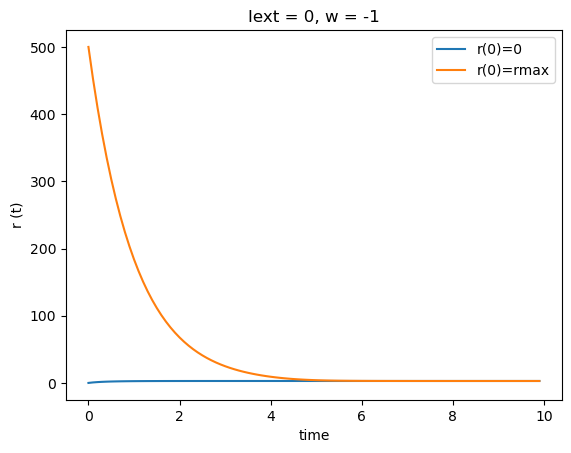

In [40]:
# plot des résultats
fig, ax = plt.subplots()
ax.set_title('Iext = %g, w = %g'%(Iext,w))
ax.plot(t, r_of_t_0, label='r(0)=0')
ax.plot(t, r_of_t_max, label='r(0)=rmax')
ax.set_xlabel('time')
ax.set_ylabel('r (t)')
ax.legend()

Si les deux valeurs initiales extremes donnent le même résultat final (après rélaxation de $r$), il n'y a qu'un seul état stationnaire stable !

Maintenant, on va regarder comment l'état final varie pour différentes valeurs de $I_{ext}$, à savoir à quoi ressemble une fonction effective de transfert ("courbe f-I") de la population avec connexions récurrentes en fonction du courant externe.

In [41]:
# valeurs de Iext à pour lequel on veut déterminer la dynamique
Iexts = np.arange(-10,100,1)

# array pour le taux de décharge stationnaire (finale)
# --> 2 valeurs par Iext (r0 = 0 et r0 = rmax)
rfinal = np.zeros((len(Iexts),2))

# boucle sur les différentes valeurs de courant externe
for i, Iext in enumerate(Iexts):
    # solution de l'équation différentielle
    # (ici, j'utilise 'odeint' mais l'intégration par 
    # la méthode Euler fonctionne aussi !)
    r_of_t_0 = odeint(drdt, r0, t, args=(Iext, w))
    r_of_t_max = odeint(drdt, rmax, t, args=(Iext, w))

    # enregistrement de l'état final de la dynamique
    # (à t = 10)
    rfinal[i,0] = r_of_t_0[-1]  
    rfinal[i,1] = r_of_t_max[-1]  

Text(0, 0.5, 'rate (Hz)')

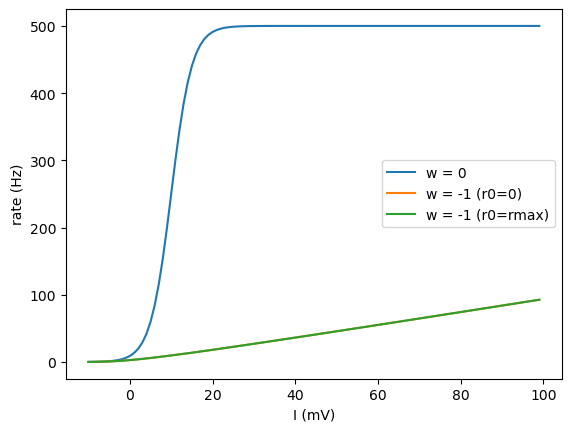

In [42]:
fig, ax = plt.subplots()
ax.plot(Iexts, fI(Iexts), label='w = 0')
ax.plot(Iexts, rfinal[:,0], label='w = %g (r0=0)'%w)
ax.plot(Iexts, rfinal[:,1], label='w = %g (r0=rmax)'%w)
ax.legend()
ax.set_xlabel('I (mV)')
ax.set_ylabel('rate (Hz)')

On observe que les connexions récurrentes inhibitrices lissent la courbe 'f-I' pour des entréees externes au niveau de la population (sans connexions récurrentes, c-à-d. pour `w=0`, cette courbe est donnée directement par la fonction $\Phi$ qui caractérise l'activité de la population en fonction du courant total).

Est-ce qu'il y a la possibilité de déterminer l'état stationnaire ($r(t)=r^*=const.$) en partant de l'équation ? Plottez $dr/dt$ en fonction de $r$ pour les valeurs de $I_{ext}$ et $w$ choisies. Qu'est-ce que vous observez ?

Text(0, 0.5, 'dr/dt (Hz/time)')

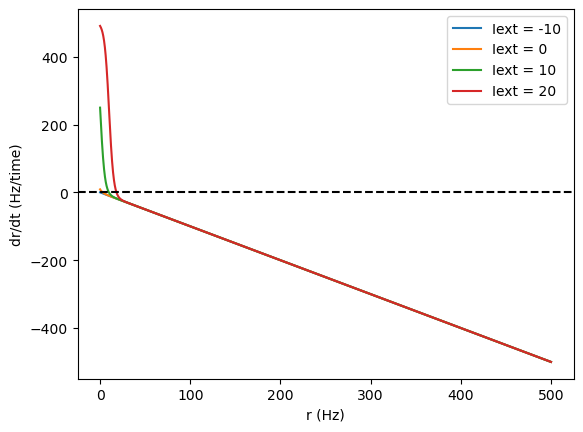

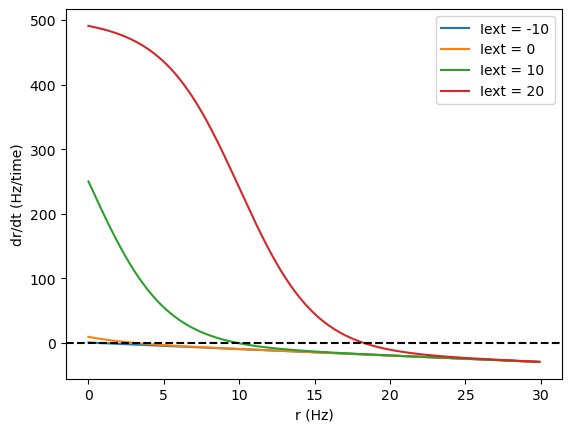

In [32]:
# différentes valeurs de Iext
Iexts = [-10, 0, 10, 20]

# array avec des valeurs de r 
r = np.arange(0,rmax,0.1)

# plot de dr/dt 
fig, ax = plt.subplots()
for Iext in Iexts:
    ax.plot(r, drdt(r,None,Iext,w), label='Iext = %g'%Iext)
ax.axhline(0, ls='--', color='k')
ax.legend()
ax.set_xlabel('r (Hz)')
ax.set_ylabel('dr/dt (Hz/time)')

# array avec des valeurs de r 
r = np.arange(0,30,0.1)

# plot de dr/dt 
fig, ax = plt.subplots()
for Iext in Iexts:
    ax.plot(r, drdt(r,None,Iext,w), label='Iext = %g'%Iext)
ax.axhline(0, ls='--', color='k')
ax.legend()
ax.set_xlabel('r (Hz)')
ax.set_ylabel('dr/dt (Hz/time)')


On voit qu'il y a un seul point fixe stable proche de l'origine ; pour des valeurs de $r$ grandes, le courant total est dominé par la récurrence et la population à tendance à se supprimer elle-même ($dr/dt<0$). Le point fixe augmente avec $I_{ext}$ mais de manière faible.

#### Excitatory network

Plottez $r(t)$ pour différentes valeurs de $I_{ext}$, maintenant avec une valeur $w>0$, chaque fois pour des valeurs initiales $r(t=0)=0$ et $r(t=0)= r_{max}$. Qu'est-ce que vous observez ?

In [ ]:
Iext = 0. # courant externe
w = 0.1   # poids recurrent --> choisir un poids un peu plus faible... 
          
# il est possible de relier ce poids aux poids synaptiques, 
# le nombre de connexions entre neurones etc., mais ici il s'agit
# surtout de montrer le fonctionnement qualitatif de ces types de réseaux

# solution numérique de l'éuation différentielle qui décrit la 
# dynamique du réseau récurrent
# --> les deux conditions initiales !
r_of_t_0 = odeint(drdt, 0, t, args=(Iext, w))
r_of_t_max = odeint(drdt, rmax, t, args=(Iext, w))

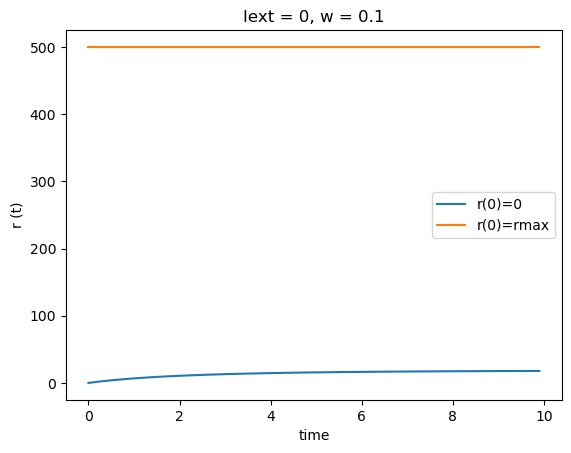

In [46]:
# plot
fig, ax = plt.subplots()
ax.set_title('Iext = %g, w = %g'%(Iext,w))
ax.plot(t, r_of_t_0, label='r(0)=0')
ax.plot(t, r_of_t_max, label='r(0)=rmax')
ax.set_xlabel('time')
ax.set_ylabel('r (t)')
ax.legend()

Pour ces premières valeurs de $I_{ext}$ et de $w$ choisies, on voit que *l'état final de l'activité dépend de la valeur initiale de l'activité !* D'où l'intéret de considérer les deux valeurs intiales extremes ($r=0, r=r_{max}$) lors de la détermination de l'activité finale / stationnaire.  

A quoi ressemblera du coup la fonction de transfert effective d'un réseau récurrent excitateur ? 

In [47]:
# valeurs de Iext à pour lequel on veut déterminer la dynamique
Iexts = np.arange(-50,30,1)

# array pour le taux de décharge stationnaire (finale)
# --> 2 valeurs par Iext (r0 = 0 et r0 = rmax)
rfinal = np.zeros((len(Iexts),2))

for i, Iext in enumerate(Iexts):
    r_of_t_0 = odeint(drdt, r0, t, args=(Iext, w))
    r_of_t_max = odeint(drdt, rmax, t, args=(Iext, w))

    rfinal[i,0] = r_of_t_0[-1]  
    rfinal[i,1] = r_of_t_max[-1]  


Text(0, 0.5, 'rate (Hz)')

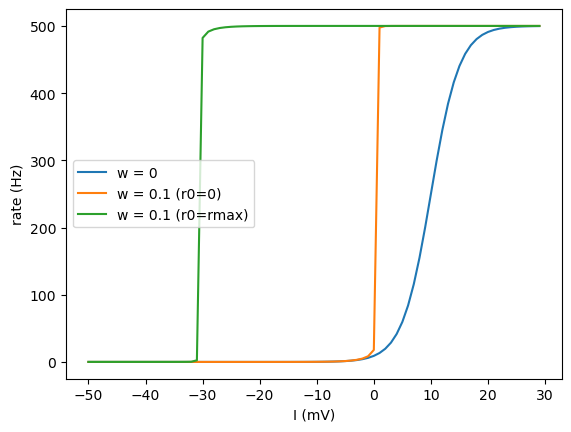

In [48]:
fig, ax = plt.subplots()
ax.plot(Iexts, fI(Iexts), label='w = 0')
ax.plot(Iexts, rfinal[:,0], label='w = %g (r0=0)'%w)
ax.plot(Iexts, rfinal[:,1], label='w = %g (r0=rmax)'%w)
ax.legend()
ax.set_xlabel('I (mV)')
ax.set_ylabel('rate (Hz)')

On voit ce qu'on appelle l'hystérese en physique (par ex. pour la magnétisation d'un aimant) : si on commence à des taux de décharge bas, le réseau reste dans un état à faible décharge (petit $r$) dans un gamme plus large de valeurs de courant d'entrée externe $I_{ext}$ que si le réseau est au début dans un état d'activité très élevée ($r\simeq r_{max}$).

Si vous plottez maintenant $dr/dt$ en fonction de $r$, qu'est-ce que vous observez ? A combien d'états stationnaires vous attendez-vous ?

Text(0, 0.5, 'dr/dt (Hz/time)')

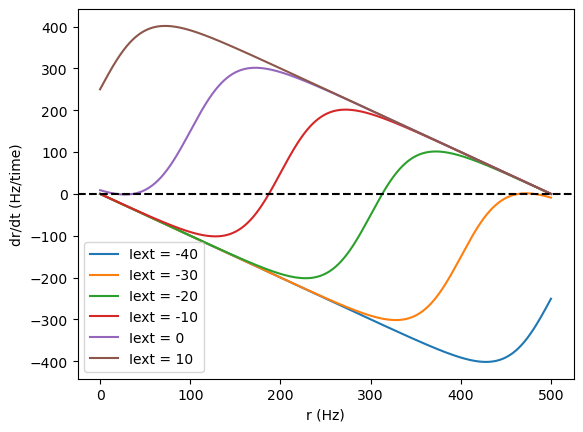

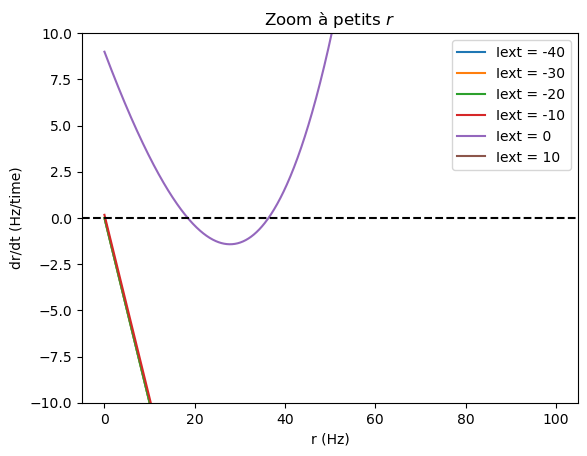

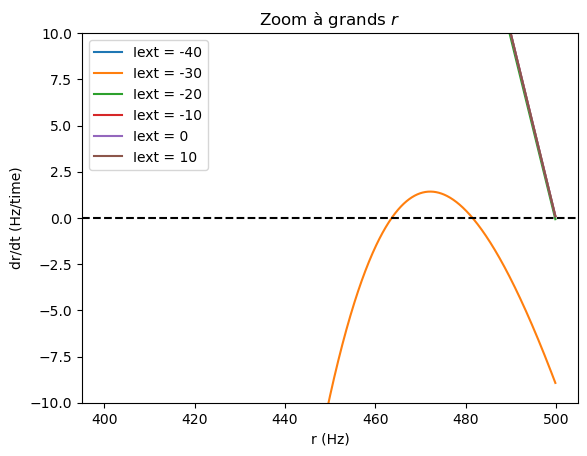

In [55]:
# différentes valeurs de Iext
Iexts = [-40, -30, -20, -10, 0, 10]

# array avec des valeurs de r 
r = np.arange(0,rmax,0.1)

# plot de dr/dt 
fig, ax = plt.subplots()
for Iext in Iexts:
    ax.plot(r, drdt(r,None,Iext,w), label='Iext = %g'%Iext)
ax.axhline(0, ls='--', color='k')
ax.legend()
ax.set_xlabel('r (Hz)')
ax.set_ylabel('dr/dt (Hz/time)')

# array avec des valeurs de r 
r = np.arange(0,100,0.1)

# plot de dr/dt 
fig, ax = plt.subplots()
ax.set_title('Zoom à petits $r$')
for Iext in Iexts:
    ax.plot(r, drdt(r,None,Iext,w), label='Iext = %g'%Iext)
ax.axhline(0, ls='--', color='k')
ax.legend()
ax.set_ylim(-10,10)
ax.set_xlabel('r (Hz)')
ax.set_ylabel('dr/dt (Hz/time)')

# array avec des valeurs de r 
r = np.arange(400,500,0.1)

# plot de dr/dt 
fig, ax = plt.subplots()
ax.set_title('Zoom à grands $r$')
for Iext in Iexts:
    ax.plot(r, drdt(r,None,Iext,w), label='Iext = %g'%Iext)
ax.axhline(0, ls='--', color='k')
ax.legend()
ax.set_ylim(-10,10)
ax.set_xlabel('r (Hz)')
ax.set_ylabel('dr/dt (Hz/time)')

On voit bien que pour des valeurs intermédiaires de $I_{ext}$, il y a bien 3 points fixes de la dynamique (pour lesquels $dr/dt=0$) : 
- un point fixe $r^*_1$ **stable** à taux de décharge petit. Si on varie $r$ un peu autour de ce point fixe, $dr/dt>0$ si $r<r^*_1$ et $dr/dt<0$ si $r>r^*_1$, donc la dynamique ramène l'activité du réseau vers ce point fixe.
- un point fixe $r^*_2$ **instable** à taux de décharge intermédiaire. Si on varie $r$ un peu autour de ce point fixe, $dr/dt<0$ si $r<r^*_2$ et $dr/dt>0$ si $r>r^*_2$, donc la dynamique va faire partir l'activité du réseau de ce point fixe.
- un point fixe $r^*_3$ **stable** à taux de décharge élevé. Si on varie $r$ un peu autour de ce point fixe, $dr/dt>0$ si $r<r^*_3$ et $dr/dt<0$ si $r>r^*_3$, donc la dynamique ramène l'activité du réseau vers ce point fixe.

Pour $I_{ext}$ très petit, il n'y a qu'un seul point fixe stable à faible taux de décharge. Inversément, pour $I_{ext}$ très élevé, il n'y a qu'un seul point fixe stable à fort taux de décharge.